In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

In [2]:
data_dir = r'C:\Users\aiforesee\Google Drive (bimapriambodowr@gmail.com)\Digital Rise Indonesia\Object Detection\Masker Detection - Resnet\experiements\data'
def load_split_train_test(datadir, valid_size = .25):
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.CenterCrop(224),
                                           transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                           transforms.RandomAffine(degrees = (-45,45), translate=None, scale=None, shear=None, resample=False, fillcolor=0),
                                           transforms.RandomRotation((-45,45)),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                           transforms.RandomVerticalFlip(p=0.5),
                                           transforms.ToTensor(),
                                           transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])
    test_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                           transforms.RandomAffine(degrees = (-45,45), translate=None, scale=None, shear=None, resample=False, fillcolor=0),
                                           transforms.RandomRotation((-45,45)),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
                                           transforms.RandomVerticalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .25)
print(trainloader.dataset.classes)

['with_mask', 'without_mask']


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
model_ft = models.mobilenet_v2(pretrained=True)

num_frts = model_ft.classifier[1].in_features #mobilenet
model_ft.classifier[1] = nn.Linear(num_frts, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
print(model_ft)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

)


In [7]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        logps = model_ft.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model_ft.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model_ft.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model_ft.train()

Epoch 1/10.. Train loss: 0.638.. Test loss: 0.398.. Test accuracy: 0.813
Epoch 1/10.. Train loss: 0.563.. Test loss: 0.314.. Test accuracy: 0.867
Epoch 1/10.. Train loss: 0.527.. Test loss: 0.245.. Test accuracy: 0.905
Epoch 1/10.. Train loss: 0.474.. Test loss: 0.240.. Test accuracy: 0.900
Epoch 1/10.. Train loss: 0.275.. Test loss: 0.228.. Test accuracy: 0.907
Epoch 1/10.. Train loss: 0.415.. Test loss: 0.146.. Test accuracy: 0.942
Epoch 1/10.. Train loss: 0.444.. Test loss: 0.135.. Test accuracy: 0.954
Epoch 1/10.. Train loss: 0.413.. Test loss: 0.157.. Test accuracy: 0.947
Epoch 1/10.. Train loss: 0.210.. Test loss: 0.105.. Test accuracy: 0.965
Epoch 1/10.. Train loss: 0.315.. Test loss: 0.131.. Test accuracy: 0.938
Epoch 1/10.. Train loss: 0.334.. Test loss: 0.089.. Test accuracy: 0.967
Epoch 1/10.. Train loss: 0.366.. Test loss: 0.097.. Test accuracy: 0.974
Epoch 1/10.. Train loss: 0.351.. Test loss: 0.094.. Test accuracy: 0.965
Epoch 1/10.. Train loss: 0.329.. Test loss: 0.098..

Epoch 3/10.. Train loss: 0.272.. Test loss: 0.038.. Test accuracy: 0.987
Epoch 3/10.. Train loss: 0.196.. Test loss: 0.042.. Test accuracy: 0.991
Epoch 3/10.. Train loss: 0.228.. Test loss: 0.043.. Test accuracy: 0.985
Epoch 3/10.. Train loss: 0.167.. Test loss: 0.047.. Test accuracy: 0.982
Epoch 3/10.. Train loss: 0.128.. Test loss: 0.042.. Test accuracy: 0.984
Epoch 3/10.. Train loss: 0.212.. Test loss: 0.040.. Test accuracy: 0.986
Epoch 3/10.. Train loss: 0.161.. Test loss: 0.045.. Test accuracy: 0.984
Epoch 3/10.. Train loss: 0.285.. Test loss: 0.048.. Test accuracy: 0.986
Epoch 3/10.. Train loss: 0.157.. Test loss: 0.046.. Test accuracy: 0.985
Epoch 3/10.. Train loss: 0.214.. Test loss: 0.043.. Test accuracy: 0.984
Epoch 3/10.. Train loss: 0.167.. Test loss: 0.036.. Test accuracy: 0.989
Epoch 3/10.. Train loss: 0.266.. Test loss: 0.045.. Test accuracy: 0.985
Epoch 3/10.. Train loss: 0.174.. Test loss: 0.038.. Test accuracy: 0.988
Epoch 3/10.. Train loss: 0.253.. Test loss: 0.043..

Epoch 5/10.. Train loss: 0.203.. Test loss: 0.037.. Test accuracy: 0.988
Epoch 5/10.. Train loss: 0.148.. Test loss: 0.039.. Test accuracy: 0.985
Epoch 5/10.. Train loss: 0.134.. Test loss: 0.037.. Test accuracy: 0.990
Epoch 5/10.. Train loss: 0.160.. Test loss: 0.034.. Test accuracy: 0.992
Epoch 5/10.. Train loss: 0.140.. Test loss: 0.034.. Test accuracy: 0.987
Epoch 5/10.. Train loss: 0.129.. Test loss: 0.039.. Test accuracy: 0.987
Epoch 5/10.. Train loss: 0.200.. Test loss: 0.034.. Test accuracy: 0.991
Epoch 5/10.. Train loss: 0.176.. Test loss: 0.034.. Test accuracy: 0.992
Epoch 5/10.. Train loss: 0.313.. Test loss: 0.040.. Test accuracy: 0.989
Epoch 5/10.. Train loss: 0.083.. Test loss: 0.034.. Test accuracy: 0.989
Epoch 5/10.. Train loss: 0.248.. Test loss: 0.035.. Test accuracy: 0.991
Epoch 5/10.. Train loss: 0.146.. Test loss: 0.039.. Test accuracy: 0.991
Epoch 5/10.. Train loss: 0.141.. Test loss: 0.036.. Test accuracy: 0.987
Epoch 5/10.. Train loss: 0.147.. Test loss: 0.040..

Epoch 7/10.. Train loss: 0.093.. Test loss: 0.032.. Test accuracy: 0.992
Epoch 7/10.. Train loss: 0.130.. Test loss: 0.028.. Test accuracy: 0.992
Epoch 7/10.. Train loss: 0.523.. Test loss: 0.030.. Test accuracy: 0.990
Epoch 7/10.. Train loss: 0.136.. Test loss: 0.030.. Test accuracy: 0.990
Epoch 7/10.. Train loss: 0.102.. Test loss: 0.029.. Test accuracy: 0.993
Epoch 7/10.. Train loss: 0.084.. Test loss: 0.031.. Test accuracy: 0.990
Epoch 7/10.. Train loss: 0.109.. Test loss: 0.028.. Test accuracy: 0.993
Epoch 7/10.. Train loss: 0.167.. Test loss: 0.028.. Test accuracy: 0.993
Epoch 7/10.. Train loss: 0.130.. Test loss: 0.029.. Test accuracy: 0.993
Epoch 7/10.. Train loss: 0.102.. Test loss: 0.032.. Test accuracy: 0.991
Epoch 7/10.. Train loss: 0.079.. Test loss: 0.033.. Test accuracy: 0.992
Epoch 8/10.. Train loss: 0.078.. Test loss: 0.032.. Test accuracy: 0.990
Epoch 8/10.. Train loss: 0.057.. Test loss: 0.032.. Test accuracy: 0.992
Epoch 8/10.. Train loss: 0.197.. Test loss: 0.031..

Epoch 10/10.. Train loss: 0.118.. Test loss: 0.021.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.092.. Test loss: 0.024.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.122.. Test loss: 0.033.. Test accuracy: 0.991
Epoch 10/10.. Train loss: 0.144.. Test loss: 0.022.. Test accuracy: 0.994
Epoch 10/10.. Train loss: 0.107.. Test loss: 0.029.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.211.. Test loss: 0.028.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.157.. Test loss: 0.029.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.112.. Test loss: 0.032.. Test accuracy: 0.991
Epoch 10/10.. Train loss: 0.046.. Test loss: 0.036.. Test accuracy: 0.988
Epoch 10/10.. Train loss: 0.107.. Test loss: 0.025.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.093.. Test loss: 0.030.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.059.. Test loss: 0.025.. Test accuracy: 0.993
Epoch 10/10.. Train loss: 0.092.. Test loss: 0.029.. Test accuracy: 0.990
Epoch 10/10.. Train loss: 0.120.. Test

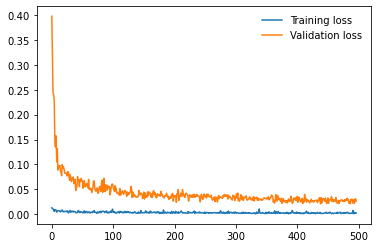

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [9]:
torch.save(model_ft, 'mask6_model.pth')
